## ResNet

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras 
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.__version__

'2.6.0'

## ResNet 기본 블록 구성하기

In [3]:
def identity_block(input_tensor, num_cnn, is_50, is_skip, channel, stage):
    bn_axis = 3
    x = input_tensor
    for i, cnn_num in enumerate(range(num_cnn)):  
        conv_name_base = 'stage' + str(stage+2) +'_'+ str(i+2) +'_'
        
        if is_50 is False:
            input_tensor = x
            x = layers.Conv2D(channel, (3,3),
                          padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)
            
            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)
        
        elif is_50 is True:
            input_tensor = x 
            x = layers.Conv2D(channel, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv1')(input_tensor)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel, (3,3),
                              padding='same',
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv2')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
            x = layers.Activation('relu')(x)

            x = layers.Conv2D(channel*4, (1, 1),
                              kernel_initializer='he_normal',
                              name=conv_name_base + 'conv3')(x)
            x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
            x = layers.Activation('relu')(x)
            
        if is_skip is True:
            x = layers.add([x, input_tensor], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x

In [4]:
def conv_block(input_tensor, is_50, is_skip, channel, stage):
    conv_name_base = 'stage' + str(stage+2) + '_1_'
    bn_axis = 3
    if stage is 0:
        strides=(1,1)
    else:
        strides=(2,2)
        
    if is_50 is False:
        x = layers.Conv2D(channel, (3,3), strides=strides, padding='same', 
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel, (1, 1), strides=strides,padding='same', 
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn3')(shortcut)
        
    elif is_50 is True:
        x = layers.Conv2D(channel, (1, 1), strides=strides,
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv1')(input_tensor)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn1')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel, (3,3), padding='same',
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv2')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn2')(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(channel*4, (1, 1),
                          kernel_initializer='he_normal',
                          name=conv_name_base + 'conv3')(x)
        x = layers.BatchNormalization(axis=bn_axis, name=conv_name_base + 'bn3')(x)
        x = layers.Activation('relu')(x)
        
        shortcut = layers.Conv2D(channel*4, (1, 1), strides=strides,
                                 kernel_initializer='he_normal',
                                 name=conv_name_base + 'short')(input_tensor)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, name=conv_name_base + 'bn4')(shortcut)
        
    if is_skip is True:
        x = layers.add([x, shortcut], name=conv_name_base+'add')
        x = layers.Activation('relu')(x)
    return x

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_4478/1407933882.py:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if stage is 0:


In [5]:
def build_resnet(input_shape=(32,32,3),
                   num_cnn_list=[2,3,5,2],
                   channel_list=[64,128,256,512],
                   is_50=False,
                   is_skip=True,
                   num_classes=10):
    assert len(num_cnn_list) is len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='input_layer')
    output = input_layer
    
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=(2,2), 
                           padding='same', name='stage1_1_conv1')(output)
    output = layers.BatchNormalization(name='stage1_1_bn1')(output)
    output = layers.Activation('relu')(output)
    
    output = layers.MaxPool2D(pool_size=(2,2), strides=2, name='stage2_0_maxpooling')(output)
    
    for i, (channel, num_cnn) in enumerate(zip(channel_list, num_cnn_list)):
        output = conv_block(
            output,
            is_50=is_50,
            is_skip=is_skip,
            channel=channel,
            stage = i
        )

        output = identity_block(
            output,
            num_cnn=num_cnn, 
            is_50=is_50,
            is_skip=is_skip,
            channel=channel, 
            stage = i
        )
        
    
    output = layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

## ResNet-34, ResNet-50 Complete Model

In [6]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
______________________________________________________________________________________________

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 16, 16, 64)   256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 16, 16, 64)   0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

## Ablation Study를 위한 (224, 224, 3) 입력 모델 만들기

In [8]:
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=True)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_114 (Activation)     (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

In [9]:
resnet_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=True)
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_1_conv1 (Conv2D)         (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
stage1_1_bn1 (BatchNormalizatio (None, 112, 112, 64) 256         stage1_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 112, 112, 64) 0           stage1_1_bn1[0][0]               
____________________________________________________________________________________________

## 일반 네트워크(plain network) 만들기

In [10]:
plain_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_skip=False)
plain_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_228 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

In [11]:
plain_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_skip=False)
plain_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_1_conv1 (Conv2D)      (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_1_bn1 (BatchNormaliza (None, 112, 112, 64)      256       
_________________________________________________________________
activation_273 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 56, 56, 64)        256 

## ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [12]:
BATCH_SIZE = 32
EPOCH = 15

### Input Normalization

In [13]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, (224, 224))
    return tf.cast(image, tf.float32) / 255., label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)

In [16]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [17]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [18]:
ds_info.features["label"].names

['cat', 'dog']

In [19]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

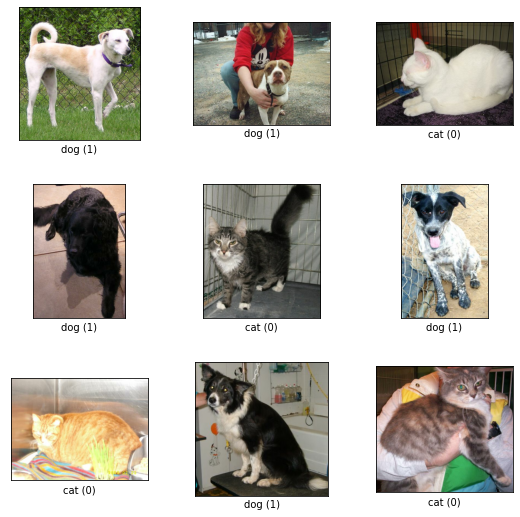

In [20]:
fig = tfds.show_examples(ds_train, ds_info)

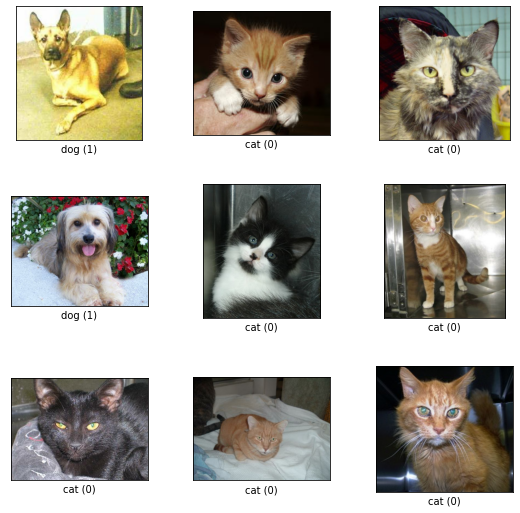

In [21]:
fig = tfds.show_examples(ds_test, ds_info)

In [22]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [23]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 29/581 [>.............................] - ETA: 1:34 - loss: 1.5826 - accuracy: 0.4591

 40/581 [=>............................] - ETA: 1:32 - loss: 1.4275 - accuracy: 0.4820

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:20 - loss: 1.2802 - accuracy: 0.5205

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 45s - loss: 1.1689 - accuracy: 0.5412

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 43s - loss: 1.1680 - accuracy: 0.5428

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 41s - loss: 1.1656 - accuracy: 0.5432

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 36s - loss: 1.1581 - accuracy: 0.5462

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 35s - loss: 1.1570 - accuracy: 0.5455

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.1023 - accuracy: 0.5661

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1019 - accuracy: 0.5662

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 169s 206ms/step - loss: 1.1019 - accuracy: 0.5662 - val_loss: 1.0148 - val_accuracy: 0.5657
Epoch 2/15
 29/581 [>.............................] - ETA: 1:40 - loss: 0.8549 - accuracy: 0.6422

 38/581 [>.............................] - ETA: 1:38 - loss: 0.8715 - accuracy: 0.6192

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:25 - loss: 0.9317 - accuracy: 0.6128

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 47s - loss: 0.9176 - accuracy: 0.6182

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 45s - loss: 0.9179 - accuracy: 0.6176

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 43s - loss: 0.9222 - accuracy: 0.6165

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 38s - loss: 0.9222 - accuracy: 0.6170

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 37s - loss: 0.9206 - accuracy: 0.6171

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


573/581 [============================>.] - ETA: 1s - loss: 0.9050 - accuracy: 0.6256

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9040 - accuracy: 0.6262

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 122s 210ms/step - loss: 0.9040 - accuracy: 0.6262 - val_loss: 0.9076 - val_accuracy: 0.6000
Epoch 3/15
 31/581 [>.............................] - ETA: 1:40 - loss: 0.7954 - accuracy: 0.6482

 40/581 [=>............................] - ETA: 1:38 - loss: 0.7925 - accuracy: 0.6492

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


110/581 [====>.........................] - ETA: 1:26 - loss: 0.7909 - accuracy: 0.6565

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 46s - loss: 0.8173 - accuracy: 0.6546

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 45s - loss: 0.8182 - accuracy: 0.6546

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 43s - loss: 0.8190 - accuracy: 0.6538

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 38s - loss: 0.8163 - accuracy: 0.6562

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 37s - loss: 0.8147 - accuracy: 0.6563

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.8120 - accuracy: 0.6663

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8109 - accuracy: 0.6665

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 207ms/step - loss: 0.8109 - accuracy: 0.6665 - val_loss: 0.7752 - val_accuracy: 0.6396
Epoch 4/15
 31/581 [>.............................] - ETA: 1:39 - loss: 0.7383 - accuracy: 0.6769

 40/581 [=>............................] - ETA: 1:37 - loss: 0.7608 - accuracy: 0.6738

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:24 - loss: 0.7777 - accuracy: 0.6777

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 47s - loss: 0.7846 - accuracy: 0.6849

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 45s - loss: 0.7807 - accuracy: 0.6852

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 43s - loss: 0.7794 - accuracy: 0.6857

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 38s - loss: 0.7773 - accuracy: 0.6859

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 37s - loss: 0.7735 - accuracy: 0.6864

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.7550 - accuracy: 0.6942

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7553 - accuracy: 0.6943

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.7553 - accuracy: 0.6943 - val_loss: 0.8265 - val_accuracy: 0.6692
Epoch 5/15
 30/581 [>.............................] - ETA: 1:40 - loss: 0.7127 - accuracy: 0.6958

 43/581 [=>............................] - ETA: 1:38 - loss: 0.6796 - accuracy: 0.7129

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:24 - loss: 0.6494 - accuracy: 0.7288

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 46s - loss: 0.6391 - accuracy: 0.7338

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 44s - loss: 0.6423 - accuracy: 0.7343

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 42s - loss: 0.6433 - accuracy: 0.7345

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 37s - loss: 0.6478 - accuracy: 0.7339

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.6475 - accuracy: 0.7344

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.7385

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.6435 - accuracy: 0.7385 - val_loss: 0.9084 - val_accuracy: 0.6694
Epoch 6/15
 33/581 [>.............................] - ETA: 1:39 - loss: 0.7045 - accuracy: 0.7860

 42/581 [=>............................] - ETA: 1:38 - loss: 0.6713 - accuracy: 0.7679

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:24 - loss: 0.6540 - accuracy: 0.7489

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 47s - loss: 0.6083 - accuracy: 0.7620

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 44s - loss: 0.6115 - accuracy: 0.7613

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 42s - loss: 0.6112 - accuracy: 0.7615

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 37s - loss: 0.6103 - accuracy: 0.7614

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 36s - loss: 0.6105 - accuracy: 0.7617

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.7674

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.5876 - accuracy: 0.7674 - val_loss: 0.6890 - val_accuracy: 0.7048
Epoch 7/15
  1/581 [..............................] - ETA: 1:44 - loss: 0.3469 - accuracy: 0.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:39 - loss: 0.5528 - accuracy: 0.7785

 45/581 [=>............................] - ETA: 1:37 - loss: 0.5491 - accuracy: 0.7861

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:24 - loss: 0.5515 - accuracy: 0.7870

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 47s - loss: 0.5254 - accuracy: 0.7910

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 44s - loss: 0.5235 - accuracy: 0.7912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 42s - loss: 0.5236 - accuracy: 0.7907

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 37s - loss: 0.5218 - accuracy: 0.7916

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 36s - loss: 0.5214 - accuracy: 0.7917

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5034 - accuracy: 0.7999

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.5034 - accuracy: 0.7999 - val_loss: 0.7698 - val_accuracy: 0.7065
Epoch 8/15
  1/581 [..............................] - ETA: 1:44 - loss: 0.9767 - accuracy: 0.7812

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:39 - loss: 0.4603 - accuracy: 0.8232

 45/581 [=>............................] - ETA: 1:37 - loss: 0.4454 - accuracy: 0.8257

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:24 - loss: 0.4509 - accuracy: 0.8151

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 46s - loss: 0.4310 - accuracy: 0.8305

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 44s - loss: 0.4295 - accuracy: 0.8311

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 42s - loss: 0.4279 - accuracy: 0.8318

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 37s - loss: 0.4258 - accuracy: 0.8324

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 36s - loss: 0.4248 - accuracy: 0.8325

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8347

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.4147 - accuracy: 0.8347 - val_loss: 0.8523 - val_accuracy: 0.7022
Epoch 9/15
  4/581 [..............................] - ETA: 1:44 - loss: 0.3534 - accuracy: 0.8672

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 1:39 - loss: 0.3411 - accuracy: 0.8627

 45/581 [=>............................] - ETA: 1:37 - loss: 0.3426 - accuracy: 0.8632

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:24 - loss: 0.3626 - accuracy: 0.8628

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 46s - loss: 0.3462 - accuracy: 0.8679

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 44s - loss: 0.3462 - accuracy: 0.8680

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 41s - loss: 0.3459 - accuracy: 0.8680

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.3417 - accuracy: 0.8682

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 35s - loss: 0.3413 - accuracy: 0.8682

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.8744

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.3263 - accuracy: 0.8744 - val_loss: 0.8856 - val_accuracy: 0.7054
Epoch 10/15
  6/581 [..............................] - ETA: 1:44 - loss: 0.3127 - accuracy: 0.8802

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:39 - loss: 0.2700 - accuracy: 0.9002

 46/581 [=>............................] - ETA: 1:37 - loss: 0.2730 - accuracy: 0.8974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:24 - loss: 0.2461 - accuracy: 0.9042

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 46s - loss: 0.2559 - accuracy: 0.9039

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 44s - loss: 0.2547 - accuracy: 0.9045

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 41s - loss: 0.2555 - accuracy: 0.9031

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.2558 - accuracy: 0.9030

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 35s - loss: 0.2554 - accuracy: 0.9031

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.9075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.2441 - accuracy: 0.9075 - val_loss: 0.8897 - val_accuracy: 0.7189
Epoch 11/15
  4/581 [..............................] - ETA: 1:44 - loss: 0.1784 - accuracy: 0.9297

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:38 - loss: 0.2009 - accuracy: 0.9178

 48/581 [=>............................] - ETA: 1:37 - loss: 0.2227 - accuracy: 0.9121

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:24 - loss: 0.2251 - accuracy: 0.9183

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 46s - loss: 0.1897 - accuracy: 0.9288

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 43s - loss: 0.1886 - accuracy: 0.9289

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 41s - loss: 0.1892 - accuracy: 0.9290

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.1856 - accuracy: 0.9301

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 35s - loss: 0.1856 - accuracy: 0.9302

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9353

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.1753 - accuracy: 0.9353 - val_loss: 0.9750 - val_accuracy: 0.7396
Epoch 12/15
  7/581 [..............................] - ETA: 1:45 - loss: 0.1187 - accuracy: 0.9598

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:39 - loss: 0.1592 - accuracy: 0.9375

 49/581 [=>............................] - ETA: 1:37 - loss: 0.1581 - accuracy: 0.9362

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:24 - loss: 0.1511 - accuracy: 0.9424

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 46s - loss: 0.1396 - accuracy: 0.9479

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 43s - loss: 0.1389 - accuracy: 0.9484

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 41s - loss: 0.1385 - accuracy: 0.9483

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 36s - loss: 0.1405 - accuracy: 0.9474

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 35s - loss: 0.1402 - accuracy: 0.9475

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9516

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.1305 - accuracy: 0.9516 - val_loss: 0.9824 - val_accuracy: 0.7102
Epoch 13/15
  6/581 [..............................] - ETA: 1:44 - loss: 0.1207 - accuracy: 0.9688

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 1:38 - loss: 0.1018 - accuracy: 0.9607

 49/581 [=>............................] - ETA: 1:37 - loss: 0.0978 - accuracy: 0.9624

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 1:23 - loss: 0.1013 - accuracy: 0.9624

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 45s - loss: 0.0945 - accuracy: 0.9660

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 43s - loss: 0.0938 - accuracy: 0.9660

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 41s - loss: 0.0923 - accuracy: 0.9667

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 36s - loss: 0.0898 - accuracy: 0.9678

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 35s - loss: 0.0901 - accuracy: 0.9676

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9694

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.0855 - accuracy: 0.9694 - val_loss: 0.9588 - val_accuracy: 0.7422
Epoch 14/15
  8/581 [..............................] - ETA: 1:44 - loss: 0.0851 - accuracy: 0.9727

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:38 - loss: 0.0639 - accuracy: 0.9797

 52/581 [=>............................] - ETA: 1:36 - loss: 0.0616 - accuracy: 0.9808

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 1:23 - loss: 0.0665 - accuracy: 0.9786

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 45s - loss: 0.0746 - accuracy: 0.9749

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 43s - loss: 0.0740 - accuracy: 0.9749

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 41s - loss: 0.0734 - accuracy: 0.9752

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 36s - loss: 0.0718 - accuracy: 0.9757

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 35s - loss: 0.0713 - accuracy: 0.9758

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9758

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.0710 - accuracy: 0.9758 - val_loss: 1.0404 - val_accuracy: 0.7465
Epoch 15/15
  8/581 [..............................] - ETA: 1:44 - loss: 0.0676 - accuracy: 0.9766

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:38 - loss: 0.0612 - accuracy: 0.9797

 53/581 [=>............................] - ETA: 1:36 - loss: 0.0618 - accuracy: 0.9782

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


126/581 [=====>........................] - ETA: 1:23 - loss: 0.0638 - accuracy: 0.9762

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 45s - loss: 0.0577 - accuracy: 0.9800

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 43s - loss: 0.0567 - accuracy: 0.9803

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


358/581 [=================>............] - ETA: 40s - loss: 0.0562 - accuracy: 0.9803

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 35s - loss: 0.0559 - accuracy: 0.9804

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


391/581 [===================>..........] - ETA: 34s - loss: 0.0555 - accuracy: 0.9807

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9818

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 0.0531 - accuracy: 0.9818 - val_loss: 1.2358 - val_accuracy: 0.7455


In [24]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 1:33 - loss: 1.1104 - accuracy: 0.4734

 38/581 [>.............................] - ETA: 1:32 - loss: 1.0426 - accuracy: 0.4844

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:20 - loss: 0.8941 - accuracy: 0.5119

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 44s - loss: 0.8525 - accuracy: 0.5162

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 42s - loss: 0.8512 - accuracy: 0.5155

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 40s - loss: 0.8490 - accuracy: 0.5149

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 35s - loss: 0.8479 - accuracy: 0.5136

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 34s - loss: 0.8475 - accuracy: 0.5146

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.8358 - accuracy: 0.5140

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.5139

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 124s 194ms/step - loss: 0.8358 - accuracy: 0.5139 - val_loss: 0.8005 - val_accuracy: 0.5214
Epoch 2/15
 30/581 [>.............................] - ETA: 1:34 - loss: 0.7793 - accuracy: 0.5250

 39/581 [=>............................] - ETA: 1:32 - loss: 0.7885 - accuracy: 0.5112

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:20 - loss: 0.8083 - accuracy: 0.5077

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 44s - loss: 0.8041 - accuracy: 0.5086

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 42s - loss: 0.8036 - accuracy: 0.5091

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.8015 - accuracy: 0.5103

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 0.8010 - accuracy: 0.5090

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 0.8016 - accuracy: 0.5080

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8032 - accuracy: 0.5061

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.8032 - accuracy: 0.5061 - val_loss: 1.2955 - val_accuracy: 0.5019
Epoch 3/15
 29/581 [>.............................] - ETA: 1:33 - loss: 0.8014 - accuracy: 0.4935

 39/581 [=>............................] - ETA: 1:32 - loss: 0.8002 - accuracy: 0.4984

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:19 - loss: 0.7855 - accuracy: 0.5090

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 44s - loss: 0.7945 - accuracy: 0.5096

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 42s - loss: 0.7955 - accuracy: 0.5084

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.7950 - accuracy: 0.5087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 0.7941 - accuracy: 0.5077

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 0.7937 - accuracy: 0.5075

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.7932 - accuracy: 0.5060

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7932 - accuracy: 0.5062

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7932 - accuracy: 0.5062 - val_loss: 3.5536 - val_accuracy: 0.5078
Epoch 4/15
 31/581 [>.............................] - ETA: 1:33 - loss: 0.7822 - accuracy: 0.5091

 42/581 [=>............................] - ETA: 1:31 - loss: 0.7863 - accuracy: 0.5104

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:19 - loss: 0.7868 - accuracy: 0.5108

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 43s - loss: 0.7834 - accuracy: 0.5077

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 42s - loss: 0.7829 - accuracy: 0.5067

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 40s - loss: 0.7818 - accuracy: 0.5067

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 35s - loss: 0.7819 - accuracy: 0.5059

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.7811 - accuracy: 0.5062

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7805 - accuracy: 0.5099

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7805 - accuracy: 0.5099 - val_loss: 0.7653 - val_accuracy: 0.5110
Epoch 5/15
 33/581 [>.............................] - ETA: 1:33 - loss: 0.7747 - accuracy: 0.5180

 42/581 [=>............................] - ETA: 1:31 - loss: 0.7776 - accuracy: 0.5171

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:19 - loss: 0.7791 - accuracy: 0.5120

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 43s - loss: 0.7779 - accuracy: 0.5157

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 0.7791 - accuracy: 0.5158

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 39s - loss: 0.7777 - accuracy: 0.5166

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 35s - loss: 0.7765 - accuracy: 0.5156

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 34s - loss: 0.7763 - accuracy: 0.5159

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7733 - accuracy: 0.5190

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7733 - accuracy: 0.5190 - val_loss: 1.4003 - val_accuracy: 0.5190
Epoch 6/15
  1/581 [..............................] - ETA: 1:38 - loss: 0.7031 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 1:33 - loss: 0.7510 - accuracy: 0.5000

 42/581 [=>............................] - ETA: 1:31 - loss: 0.7531 - accuracy: 0.5060

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:19 - loss: 0.7640 - accuracy: 0.5183

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 43s - loss: 0.7723 - accuracy: 0.5129

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 0.7707 - accuracy: 0.5132

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 39s - loss: 0.7717 - accuracy: 0.5127

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 34s - loss: 0.7702 - accuracy: 0.5143

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 33s - loss: 0.7692 - accuracy: 0.5147

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7687 - accuracy: 0.5174

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7687 - accuracy: 0.5174 - val_loss: 0.8492 - val_accuracy: 0.5332
Epoch 7/15
  3/581 [..............................] - ETA: 1:37 - loss: 0.7934 - accuracy: 0.5732

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 1:33 - loss: 0.7475 - accuracy: 0.5139

 44/581 [=>............................] - ETA: 1:31 - loss: 0.7563 - accuracy: 0.5115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 0.7481 - accuracy: 0.5277

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 43s - loss: 0.7497 - accuracy: 0.5300

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 41s - loss: 0.7485 - accuracy: 0.5303

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 39s - loss: 0.7473 - accuracy: 0.5308

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 34s - loss: 0.7486 - accuracy: 0.5302

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 33s - loss: 0.7491 - accuracy: 0.5295

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7489 - accuracy: 0.5272

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7489 - accuracy: 0.5272 - val_loss: 0.8169 - val_accuracy: 0.5292
Epoch 8/15
  5/581 [..............................] - ETA: 1:37 - loss: 0.7440 - accuracy: 0.5250

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:33 - loss: 0.7337 - accuracy: 0.5239

 47/581 [=>............................] - ETA: 1:30 - loss: 0.7273 - accuracy: 0.5362

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:18 - loss: 0.7453 - accuracy: 0.5351

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 43s - loss: 0.7427 - accuracy: 0.5376

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 41s - loss: 0.7432 - accuracy: 0.5363

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 39s - loss: 0.7423 - accuracy: 0.5374

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 0.7423 - accuracy: 0.5363

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 33s - loss: 0.7427 - accuracy: 0.5357

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.5363

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7414 - accuracy: 0.5363 - val_loss: 2.2975 - val_accuracy: 0.4836
Epoch 9/15
  3/581 [..............................] - ETA: 1:38 - loss: 0.6897 - accuracy: 0.6146

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:32 - loss: 0.7422 - accuracy: 0.5481

 47/581 [=>............................] - ETA: 1:31 - loss: 0.7476 - accuracy: 0.5565

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:18 - loss: 0.7483 - accuracy: 0.5435

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 43s - loss: 0.7424 - accuracy: 0.5289

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 41s - loss: 0.7421 - accuracy: 0.5301

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 39s - loss: 0.7412 - accuracy: 0.5293

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 0.7399 - accuracy: 0.5336

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 33s - loss: 0.7402 - accuracy: 0.5339

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.5374

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7371 - accuracy: 0.5374 - val_loss: 0.6930 - val_accuracy: 0.5444
Epoch 10/15
  6/581 [..............................] - ETA: 1:37 - loss: 0.7055 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:32 - loss: 0.7391 - accuracy: 0.5217

 49/581 [=>............................] - ETA: 1:30 - loss: 0.7396 - accuracy: 0.5357

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 1:18 - loss: 0.7393 - accuracy: 0.5386

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 43s - loss: 0.7296 - accuracy: 0.5502

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 40s - loss: 0.7301 - accuracy: 0.5519

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 39s - loss: 0.7289 - accuracy: 0.5526

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 0.7293 - accuracy: 0.5531

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 33s - loss: 0.7284 - accuracy: 0.5541

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7295 - accuracy: 0.5535

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7295 - accuracy: 0.5535 - val_loss: 1.1540 - val_accuracy: 0.5705
Epoch 11/15
  6/581 [..............................] - ETA: 1:37 - loss: 0.7159 - accuracy: 0.5573

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:31 - loss: 0.7316 - accuracy: 0.5624

 48/581 [=>............................] - ETA: 1:30 - loss: 0.7326 - accuracy: 0.5552

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:18 - loss: 0.7300 - accuracy: 0.5588

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 42s - loss: 0.7223 - accuracy: 0.5648

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 40s - loss: 0.7232 - accuracy: 0.5651

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 38s - loss: 0.7239 - accuracy: 0.5662

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 34s - loss: 0.7235 - accuracy: 0.5683

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 33s - loss: 0.7241 - accuracy: 0.5682

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.5747

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.7197 - accuracy: 0.5747 - val_loss: 1.9002 - val_accuracy: 0.4987
Epoch 12/15
  9/581 [..............................] - ETA: 1:37 - loss: 0.7374 - accuracy: 0.6007

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:32 - loss: 0.7084 - accuracy: 0.5814

 49/581 [=>............................] - ETA: 1:30 - loss: 0.7075 - accuracy: 0.5823

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 1:18 - loss: 0.7140 - accuracy: 0.5739

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 42s - loss: 0.7079 - accuracy: 0.5869

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 40s - loss: 0.7083 - accuracy: 0.5867

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 38s - loss: 0.7076 - accuracy: 0.5882

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 33s - loss: 0.7051 - accuracy: 0.5907

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 32s - loss: 0.7054 - accuracy: 0.5901

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.5971

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.6997 - accuracy: 0.5971 - val_loss: 0.7549 - val_accuracy: 0.5517
Epoch 13/15
  8/581 [..............................] - ETA: 1:37 - loss: 0.7177 - accuracy: 0.5391

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 1:32 - loss: 0.7033 - accuracy: 0.5897

 49/581 [=>............................] - ETA: 1:30 - loss: 0.7049 - accuracy: 0.6001

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 1:17 - loss: 0.7048 - accuracy: 0.5960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 42s - loss: 0.6972 - accuracy: 0.6043

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 40s - loss: 0.6966 - accuracy: 0.6039

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 38s - loss: 0.6974 - accuracy: 0.6037

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 33s - loss: 0.6975 - accuracy: 0.6041

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 32s - loss: 0.6968 - accuracy: 0.6042

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6937 - accuracy: 0.6062

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.6937 - accuracy: 0.6062 - val_loss: 0.8333 - val_accuracy: 0.6017
Epoch 14/15
 11/581 [..............................] - ETA: 1:36 - loss: 0.7139 - accuracy: 0.6136

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 1:32 - loss: 0.6722 - accuracy: 0.6375

 50/581 [=>............................] - ETA: 1:30 - loss: 0.6755 - accuracy: 0.6331

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 1:17 - loss: 0.6804 - accuracy: 0.6294

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 42s - loss: 0.6776 - accuracy: 0.6284

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 40s - loss: 0.6780 - accuracy: 0.6282

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 38s - loss: 0.6784 - accuracy: 0.6286

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 33s - loss: 0.6768 - accuracy: 0.6287

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


390/581 [===================>..........] - ETA: 32s - loss: 0.6766 - accuracy: 0.6291

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.6356

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.6704 - accuracy: 0.6356 - val_loss: 0.7707 - val_accuracy: 0.5652
Epoch 15/15
 12/581 [..............................] - ETA: 1:36 - loss: 0.7006 - accuracy: 0.6094

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 42/581 [=>............................] - ETA: 1:31 - loss: 0.6660 - accuracy: 0.6369

 52/581 [=>............................] - ETA: 1:30 - loss: 0.6625 - accuracy: 0.6424

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 1:17 - loss: 0.6642 - accuracy: 0.6471

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 42s - loss: 0.6665 - accuracy: 0.6414

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 0.6671 - accuracy: 0.6408

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 38s - loss: 0.6659 - accuracy: 0.6413

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 33s - loss: 0.6646 - accuracy: 0.6440

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


390/581 [===================>..........] - ETA: 32s - loss: 0.6656 - accuracy: 0.6425

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.6408

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 112s 193ms/step - loss: 0.6637 - accuracy: 0.6408 - val_loss: 0.8902 - val_accuracy: 0.5396


In [25]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 3:06 - loss: 1.8799 - accuracy: 0.4799

 39/581 [=>............................] - ETA: 3:03 - loss: 1.7793 - accuracy: 0.4968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


112/581 [====>.........................] - ETA: 2:40 - loss: 1.6546 - accuracy: 0.5145

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:28 - loss: 1.5521 - accuracy: 0.5276

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:24 - loss: 1.5507 - accuracy: 0.5278

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:20 - loss: 1.5422 - accuracy: 0.5281

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 1:11 - loss: 1.5253 - accuracy: 0.5287

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 1:09 - loss: 1.5254 - accuracy: 0.5286

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


568/581 [============================>.] - ETA: 4s - loss: 1.4784 - accuracy: 0.5319

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4737 - accuracy: 0.5324

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 235s 376ms/step - loss: 1.4737 - accuracy: 0.5324 - val_loss: 2.7114 - val_accuracy: 0.5017
Epoch 2/15
 30/581 [>.............................] - ETA: 3:06 - loss: 1.3257 - accuracy: 0.5510

 38/581 [>.............................] - ETA: 3:04 - loss: 1.3241 - accuracy: 0.5502

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:38 - loss: 1.2750 - accuracy: 0.5515

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:27 - loss: 1.2748 - accuracy: 0.5612

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:24 - loss: 1.2757 - accuracy: 0.5603

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:19 - loss: 1.2743 - accuracy: 0.5611

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 1:10 - loss: 1.2726 - accuracy: 0.5611

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 1:09 - loss: 1.2716 - accuracy: 0.5613

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.2428 - accuracy: 0.5648

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.2419 - accuracy: 0.5649

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 217s 374ms/step - loss: 1.2419 - accuracy: 0.5649 - val_loss: 2.9775 - val_accuracy: 0.5225
Epoch 3/15
 16/581 [..............................] - ETA: 3:06 - loss: 1.1509 - accuracy: 0.5783

 42/581 [=>............................] - ETA: 3:01 - loss: 1.1383 - accuracy: 0.5887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:37 - loss: 1.1503 - accuracy: 0.5824

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:27 - loss: 1.1312 - accuracy: 0.5843

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:24 - loss: 1.1283 - accuracy: 0.5843

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:20 - loss: 1.1267 - accuracy: 0.5847

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 1:11 - loss: 1.1299 - accuracy: 0.5845

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 1:09 - loss: 1.1276 - accuracy: 0.5843

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


571/581 [============================>.] - ETA: 3s - loss: 1.1322 - accuracy: 0.5844

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1311 - accuracy: 0.5842

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 1.1311 - accuracy: 0.5842 - val_loss: 3.7907 - val_accuracy: 0.5526
Epoch 4/15
 33/581 [>.............................] - ETA: 3:06 - loss: 1.1309 - accuracy: 0.5994

 42/581 [=>............................] - ETA: 3:03 - loss: 1.1204 - accuracy: 0.5908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 2:39 - loss: 1.0662 - accuracy: 0.6032

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:26 - loss: 1.0474 - accuracy: 0.6074

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:23 - loss: 1.0436 - accuracy: 0.6087

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:19 - loss: 1.0478 - accuracy: 0.6076

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 1:10 - loss: 1.0464 - accuracy: 0.6072

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:08 - loss: 1.0428 - accuracy: 0.6075

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.0332 - accuracy: 0.6112

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 1.0332 - accuracy: 0.6112 - val_loss: 2.7509 - val_accuracy: 0.5256
Epoch 5/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 22/581 [>.............................] - ETA: 3:09 - loss: 1.1884 - accuracy: 0.5895

 44/581 [=>............................] - ETA: 3:02 - loss: 1.0484 - accuracy: 0.6009

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:38 - loss: 0.9940 - accuracy: 0.6152

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:27 - loss: 0.9729 - accuracy: 0.6260

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:23 - loss: 0.9716 - accuracy: 0.6262

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:19 - loss: 0.9850 - accuracy: 0.6250

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:10 - loss: 0.9826 - accuracy: 0.6272

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 1:08 - loss: 0.9804 - accuracy: 0.6275

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


575/581 [============================>.] - ETA: 2s - loss: 0.9884 - accuracy: 0.6329

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9869 - accuracy: 0.6332

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.9869 - accuracy: 0.6332 - val_loss: 1.5736 - val_accuracy: 0.5810
Epoch 6/15
 31/581 [>.............................] - ETA: 3:07 - loss: 0.8559 - accuracy: 0.6623

 46/581 [=>............................] - ETA: 3:02 - loss: 0.8934 - accuracy: 0.6651

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:37 - loss: 0.9723 - accuracy: 0.6515

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:26 - loss: 0.9840 - accuracy: 0.6437

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:22 - loss: 0.9779 - accuracy: 0.6445

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:19 - loss: 0.9786 - accuracy: 0.6444

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:10 - loss: 0.9803 - accuracy: 0.6454

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 1:08 - loss: 0.9787 - accuracy: 0.6456

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.9655 - accuracy: 0.6465

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9658 - accuracy: 0.6462

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.9658 - accuracy: 0.6462 - val_loss: 1.6179 - val_accuracy: 0.5530
Epoch 7/15
 23/581 [>.............................] - ETA: 3:09 - loss: 0.9953 - accuracy: 0.6739

 46/581 [=>............................] - ETA: 3:02 - loss: 0.9386 - accuracy: 0.6603

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:37 - loss: 0.9676 - accuracy: 0.6597

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:26 - loss: 0.9566 - accuracy: 0.6483

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:22 - loss: 0.9561 - accuracy: 0.6476

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:18 - loss: 0.9535 - accuracy: 0.6476

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 1:09 - loss: 0.9536 - accuracy: 0.6469

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 1:07 - loss: 0.9521 - accuracy: 0.6481

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


575/581 [============================>.] - ETA: 2s - loss: 0.9389 - accuracy: 0.6470

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9379 - accuracy: 0.6476

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.9379 - accuracy: 0.6476 - val_loss: 0.9950 - val_accuracy: 0.6457
Epoch 8/15
 34/581 [>.............................] - ETA: 3:06 - loss: 0.9400 - accuracy: 0.6498

 45/581 [=>............................] - ETA: 3:02 - loss: 0.9583 - accuracy: 0.6576

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 2:35 - loss: 0.9639 - accuracy: 0.6573

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:26 - loss: 0.9395 - accuracy: 0.6655

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:22 - loss: 0.9370 - accuracy: 0.6644

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 1:17 - loss: 0.9388 - accuracy: 0.6659

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 1:08 - loss: 0.9368 - accuracy: 0.6649

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 1:06 - loss: 0.9394 - accuracy: 0.6650

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9347 - accuracy: 0.6726

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.9347 - accuracy: 0.6726 - val_loss: 0.8265 - val_accuracy: 0.6565
Epoch 9/15
  3/581 [..............................] - ETA: 3:14 - loss: 0.6345 - accuracy: 0.7500

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 3:07 - loss: 0.8042 - accuracy: 0.6842

 48/581 [=>............................] - ETA: 3:01 - loss: 0.8208 - accuracy: 0.6803

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 2:36 - loss: 0.8699 - accuracy: 0.6778

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 1:25 - loss: 0.8885 - accuracy: 0.6829

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:21 - loss: 0.8878 - accuracy: 0.6830

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 1:17 - loss: 0.8868 - accuracy: 0.6831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 1:08 - loss: 0.8782 - accuracy: 0.6853

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 1:06 - loss: 0.8775 - accuracy: 0.6854

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8880 - accuracy: 0.6865

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.8880 - accuracy: 0.6865 - val_loss: 0.9150 - val_accuracy: 0.6994
Epoch 10/15
  3/581 [..............................] - ETA: 3:14 - loss: 0.8696 - accuracy: 0.6667

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 3:05 - loss: 0.8931 - accuracy: 0.6918

 48/581 [=>............................] - ETA: 3:01 - loss: 0.8793 - accuracy: 0.6947

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:36 - loss: 0.8816 - accuracy: 0.6919

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:24 - loss: 0.8343 - accuracy: 0.7031

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 1:21 - loss: 0.8360 - accuracy: 0.7028

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:18 - loss: 0.8448 - accuracy: 0.7025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:09 - loss: 0.8358 - accuracy: 0.7032

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 1:07 - loss: 0.8351 - accuracy: 0.7028

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8189 - accuracy: 0.7073

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.8189 - accuracy: 0.7073 - val_loss: 1.0072 - val_accuracy: 0.6825
Epoch 11/15
  9/581 [..............................] - ETA: 3:13 - loss: 0.7283 - accuracy: 0.7569

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 25/581 [>.............................] - ETA: 3:08 - loss: 0.8204 - accuracy: 0.7212

 49/581 [=>............................] - ETA: 3:00 - loss: 0.7765 - accuracy: 0.7162

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:36 - loss: 0.8465 - accuracy: 0.6977

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 1:25 - loss: 0.7962 - accuracy: 0.7104

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 1:21 - loss: 0.7982 - accuracy: 0.7109

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 1:17 - loss: 0.7902 - accuracy: 0.7124

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 1:07 - loss: 0.7914 - accuracy: 0.7143

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 1:05 - loss: 0.7893 - accuracy: 0.7149

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7974 - accuracy: 0.7181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.7974 - accuracy: 0.7181 - val_loss: 1.3044 - val_accuracy: 0.7084
Epoch 12/15
  8/581 [..............................] - ETA: 3:13 - loss: 0.6337 - accuracy: 0.7695

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 3:04 - loss: 0.7843 - accuracy: 0.7407

 52/581 [=>............................] - ETA: 3:00 - loss: 0.7566 - accuracy: 0.7452

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 2:36 - loss: 0.7671 - accuracy: 0.7306

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:24 - loss: 0.7572 - accuracy: 0.7323

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:20 - loss: 0.7608 - accuracy: 0.7322

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:18 - loss: 0.7631 - accuracy: 0.7321

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:09 - loss: 0.7599 - accuracy: 0.7324

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 1:07 - loss: 0.7580 - accuracy: 0.7321

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7616 - accuracy: 0.7314

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.7616 - accuracy: 0.7314 - val_loss: 1.3225 - val_accuracy: 0.6272
Epoch 13/15
  9/581 [..............................] - ETA: 3:13 - loss: 0.8046 - accuracy: 0.7743

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 25/581 [>.............................] - ETA: 3:08 - loss: 0.7532 - accuracy: 0.7625

 53/581 [=>............................] - ETA: 2:59 - loss: 0.7324 - accuracy: 0.7612

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 2:35 - loss: 0.7315 - accuracy: 0.7457

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:24 - loss: 0.7119 - accuracy: 0.7522

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:20 - loss: 0.7127 - accuracy: 0.7520

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 1:16 - loss: 0.7123 - accuracy: 0.7524

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 1:07 - loss: 0.7095 - accuracy: 0.7532

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 1:05 - loss: 0.7091 - accuracy: 0.7524

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 0.7173 - accuracy: 0.7517

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.7518

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.7168 - accuracy: 0.7518 - val_loss: 0.9549 - val_accuracy: 0.6868
Epoch 14/15
 40/581 [=>............................] - ETA: 3:03 - loss: 0.6788 - accuracy: 0.7656

 54/581 [=>............................] - ETA: 2:59 - loss: 0.6871 - accuracy: 0.7587

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 2:33 - loss: 0.6956 - accuracy: 0.7527

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:23 - loss: 0.6999 - accuracy: 0.7572

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:19 - loss: 0.7016 - accuracy: 0.7588

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


358/581 [=================>............] - ETA: 1:15 - loss: 0.7050 - accuracy: 0.7575

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 1:06 - loss: 0.7041 - accuracy: 0.7588

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


390/581 [===================>..........] - ETA: 1:04 - loss: 0.7025 - accuracy: 0.7599

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.7610

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 373ms/step - loss: 0.6981 - accuracy: 0.7610 - val_loss: 0.9868 - val_accuracy: 0.6815
Epoch 15/15
 11/581 [..............................] - ETA: 3:12 - loss: 0.7131 - accuracy: 0.7557

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 3:07 - loss: 0.7672 - accuracy: 0.7627

 54/581 [=>............................] - ETA: 2:59 - loss: 0.7559 - accuracy: 0.7593

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 2:35 - loss: 0.6782 - accuracy: 0.7760

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:23 - loss: 0.6431 - accuracy: 0.7771

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 1:19 - loss: 0.6375 - accuracy: 0.7776

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 1:16 - loss: 0.6345 - accuracy: 0.7800

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 1:06 - loss: 0.6407 - accuracy: 0.7815

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 1:04 - loss: 0.6395 - accuracy: 0.7816

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6249 - accuracy: 0.7846

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 216s 372ms/step - loss: 0.6249 - accuracy: 0.7846 - val_loss: 0.9063 - val_accuracy: 0.7245


In [26]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 19/581 [..............................] - ETA: 2:34 - loss: 1.3600 - accuracy: 0.4062

 41/581 [=>............................] - ETA: 2:28 - loss: 1.0965 - accuracy: 0.4634

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


109/581 [====>.........................] - ETA: 2:11 - loss: 0.9676 - accuracy: 0.4880

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:11 - loss: 0.8890 - accuracy: 0.5060

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:08 - loss: 0.8879 - accuracy: 0.5049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:05 - loss: 0.8865 - accuracy: 0.5055

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 58s - loss: 0.8832 - accuracy: 0.5069

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 56s - loss: 0.8833 - accuracy: 0.5062

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


573/581 [============================>.] - ETA: 2s - loss: 0.8722 - accuracy: 0.5117

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8720 - accuracy: 0.5112

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 193s 308ms/step - loss: 0.8720 - accuracy: 0.5112 - val_loss: 0.7753 - val_accuracy: 0.5112
Epoch 2/15
 29/581 [>.............................] - ETA: 2:33 - loss: 0.8476 - accuracy: 0.4989

 38/581 [>.............................] - ETA: 2:30 - loss: 0.8415 - accuracy: 0.5099

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:10 - loss: 0.8363 - accuracy: 0.5184

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 1:12 - loss: 0.8449 - accuracy: 0.5134

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:09 - loss: 0.8431 - accuracy: 0.5144

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:05 - loss: 0.8417 - accuracy: 0.5152

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 58s - loss: 0.8378 - accuracy: 0.5167

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 56s - loss: 0.8384 - accuracy: 0.5163

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8396 - accuracy: 0.5167

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 179s 308ms/step - loss: 0.8396 - accuracy: 0.5167 - val_loss: 0.7510 - val_accuracy: 0.5102
Epoch 3/15
  1/581 [..............................] - ETA: 2:38 - loss: 0.8293 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 2:32 - loss: 0.8716 - accuracy: 0.4979

 44/581 [=>............................] - ETA: 2:28 - loss: 0.8560 - accuracy: 0.4972

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:09 - loss: 0.8467 - accuracy: 0.5160

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:11 - loss: 0.8311 - accuracy: 0.5156

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:07 - loss: 0.8302 - accuracy: 0.5166

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:07 - loss: 0.8307 - accuracy: 0.5166

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


362/581 [=================>............] - ETA: 1:00 - loss: 0.8272 - accuracy: 0.5174

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


368/581 [==================>...........] - ETA: 58s - loss: 0.8269 - accuracy: 0.5171

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.8325 - accuracy: 0.5119

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.5118

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 178s 306ms/step - loss: 0.8324 - accuracy: 0.5118 - val_loss: 0.9358 - val_accuracy: 0.5136
Epoch 4/15
 34/581 [>.............................] - ETA: 2:31 - loss: 0.8382 - accuracy: 0.5129

 40/581 [=>............................] - ETA: 2:29 - loss: 0.8414 - accuracy: 0.5055

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 99/581 [====>.........................] - ETA: 2:13 - loss: 0.8254 - accuracy: 0.5196

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:11 - loss: 0.8332 - accuracy: 0.5081

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:08 - loss: 0.8338 - accuracy: 0.5069

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 1:04 - loss: 0.8368 - accuracy: 0.5064

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 57s - loss: 0.8397 - accuracy: 0.5057

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 55s - loss: 0.8395 - accuracy: 0.5062

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8365 - accuracy: 0.5096

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 178s 306ms/step - loss: 0.8365 - accuracy: 0.5096 - val_loss: 1.8171 - val_accuracy: 0.5037
Epoch 5/15
  1/581 [..............................] - ETA: 2:38 - loss: 0.6747 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 2:31 - loss: 0.8398 - accuracy: 0.5184

 44/581 [=>............................] - ETA: 2:28 - loss: 0.8679 - accuracy: 0.5007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:09 - loss: 0.8476 - accuracy: 0.5158

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:10 - loss: 0.8395 - accuracy: 0.5265

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 1:07 - loss: 0.8376 - accuracy: 0.5270

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 1:03 - loss: 0.8386 - accuracy: 0.5264

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 56s - loss: 0.8381 - accuracy: 0.5266

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 55s - loss: 0.8378 - accuracy: 0.5265

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8419 - accuracy: 0.5228

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 178s 307ms/step - loss: 0.8419 - accuracy: 0.5228 - val_loss: 0.9208 - val_accuracy: 0.5386
Epoch 6/15
  1/581 [..............................] - ETA: 2:39 - loss: 0.8149 - accuracy: 0.4688

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 2:31 - loss: 0.8534 - accuracy: 0.4768

 45/581 [=>............................] - ETA: 2:28 - loss: 0.8373 - accuracy: 0.4750

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:09 - loss: 0.8353 - accuracy: 0.4973

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


313/581 [===============>..............] - ETA: 1:14 - loss: 0.8259 - accuracy: 0.5081

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:07 - loss: 0.8278 - accuracy: 0.5059

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:04 - loss: 0.8255 - accuracy: 0.5085

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 56s - loss: 0.8285 - accuracy: 0.5080

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 55s - loss: 0.8288 - accuracy: 0.5073

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8306 - accuracy: 0.5090

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 178s 306ms/step - loss: 0.8306 - accuracy: 0.5090 - val_loss: 2.3222 - val_accuracy: 0.5185
Epoch 7/15
  4/581 [..............................] - ETA: 2:38 - loss: 0.7990 - accuracy: 0.5156

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 2:31 - loss: 0.8198 - accuracy: 0.5230

 45/581 [=>............................] - ETA: 2:28 - loss: 0.8163 - accuracy: 0.5257

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:08 - loss: 0.8183 - accuracy: 0.5254

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


316/581 [===============>..............] - ETA: 1:13 - loss: 0.8274 - accuracy: 0.5110

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:07 - loss: 0.8282 - accuracy: 0.5097

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 1:04 - loss: 0.8280 - accuracy: 0.5097

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 56s - loss: 0.8281 - accuracy: 0.5085

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 55s - loss: 0.8296 - accuracy: 0.5070

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.5089

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 178s 307ms/step - loss: 0.8324 - accuracy: 0.5089 - val_loss: 1.8513 - val_accuracy: 0.4830
Epoch 8/15
  6/581 [..............................] - ETA: 2:38 - loss: 0.9112 - accuracy: 0.4948

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:31 - loss: 0.8271 - accuracy: 0.4971

 48/581 [=>............................] - ETA: 2:27 - loss: 0.8182 - accuracy: 0.4915

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:08 - loss: 0.8370 - accuracy: 0.5029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


311/581 [===============>..............] - ETA: 1:14 - loss: 0.8388 - accuracy: 0.5063

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 1:06 - loss: 0.8353 - accuracy: 0.5075

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 1:03 - loss: 0.8340 - accuracy: 0.5077

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 56s - loss: 0.8353 - accuracy: 0.5064

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 55s - loss: 0.8346 - accuracy: 0.5062

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8350 - accuracy: 0.5018

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 178s 306ms/step - loss: 0.8350 - accuracy: 0.5018 - val_loss: 1.2896 - val_accuracy: 0.5071
Epoch 9/15
  7/581 [..............................] - ETA: 2:38 - loss: 0.9042 - accuracy: 0.5223

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 2:32 - loss: 0.8144 - accuracy: 0.5166

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 2:31 - loss: 0.8064 - accuracy: 0.5196

122/581 [=====>........................] - ETA: 2:07 - loss: 0.8388 - accuracy: 0.5105

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 1:10 - loss: 0.8395 - accuracy: 0.5037

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 1:03 - loss: 0.8401 - accuracy: 0.5044

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 56s - loss: 0.8402 - accuracy: 0.5039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 55s - loss: 0.8416 - accuracy: 0.5038

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8396 - accuracy: 0.5021

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 179s 308ms/step - loss: 0.8396 - accuracy: 0.5021 - val_loss: 1.4593 - val_accuracy: 0.5242
Epoch 10/15
  4/581 [..............................] - ETA: 2:39 - loss: 0.8729 - accuracy: 0.5781

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 2:30 - loss: 0.8494 - accuracy: 0.5051

 48/581 [=>............................] - ETA: 2:27 - loss: 0.8461 - accuracy: 0.5039

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


109/581 [====>.........................] - ETA: 2:11 - loss: 0.8248 - accuracy: 0.4991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:09 - loss: 0.8391 - accuracy: 0.4987

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 1:06 - loss: 0.8394 - accuracy: 0.4984

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 1:03 - loss: 0.8404 - accuracy: 0.4983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 55s - loss: 0.8394 - accuracy: 0.5006

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 54s - loss: 0.8396 - accuracy: 0.4992

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8418 - accuracy: 0.4975

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 178s 306ms/step - loss: 0.8418 - accuracy: 0.4975 - val_loss: 0.7145 - val_accuracy: 0.4901
Epoch 11/15
  9/581 [..............................] - ETA: 2:37 - loss: 0.8012 - accuracy: 0.5104

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 2:30 - loss: 0.8459 - accuracy: 0.4966

 48/581 [=>............................] - ETA: 2:27 - loss: 0.8477 - accuracy: 0.4902

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 2:08 - loss: 0.8379 - accuracy: 0.4982

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 1:09 - loss: 0.8336 - accuracy: 0.5010

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 1:06 - loss: 0.8360 - accuracy: 0.5010

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:04 - loss: 0.8356 - accuracy: 0.5019

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 57s - loss: 0.8353 - accuracy: 0.5016

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 55s - loss: 0.8375 - accuracy: 0.5008

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8434 - accuracy: 0.4995

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 178s 306ms/step - loss: 0.8434 - accuracy: 0.4995 - val_loss: 0.8449 - val_accuracy: 0.5056
Epoch 12/15
  8/581 [..............................] - ETA: 2:38 - loss: 0.8612 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 2:30 - loss: 0.8360 - accuracy: 0.5156

 51/581 [=>............................] - ETA: 2:27 - loss: 0.8349 - accuracy: 0.5202

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 2:07 - loss: 0.8327 - accuracy: 0.5181

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:08 - loss: 0.8265 - accuracy: 0.5040

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:05 - loss: 0.8270 - accuracy: 0.5024

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 1:02 - loss: 0.8271 - accuracy: 0.5027

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 55s - loss: 0.8290 - accuracy: 0.5027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 53s - loss: 0.8293 - accuracy: 0.5023

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.5030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 179s 307ms/step - loss: 0.8272 - accuracy: 0.5030 - val_loss: 1.3339 - val_accuracy: 0.5130
Epoch 13/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 40/581 [=>............................] - ETA: 2:29 - loss: 0.8933 - accuracy: 0.5086

 53/581 [=>............................] - ETA: 2:26 - loss: 0.8729 - accuracy: 0.5088

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


127/581 [=====>........................] - ETA: 2:06 - loss: 0.8705 - accuracy: 0.4990

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:11 - loss: 0.8336 - accuracy: 0.5062

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:04 - loss: 0.8313 - accuracy: 0.5052

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 1:02 - loss: 0.8303 - accuracy: 0.5048

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 54s - loss: 0.8315 - accuracy: 0.5079

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 53s - loss: 0.8315 - accuracy: 0.5086

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8335 - accuracy: 0.5073

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 181s 311ms/step - loss: 0.8335 - accuracy: 0.5073 - val_loss: 1.5179 - val_accuracy: 0.4959
Epoch 14/15
  9/581 [..............................] - ETA: 2:37 - loss: 0.8106 - accuracy: 0.5417

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 25/581 [>.............................] - ETA: 2:33 - loss: 0.8284 - accuracy: 0.5263

 51/581 [=>............................] - ETA: 2:27 - loss: 0.8521 - accuracy: 0.5043

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 2:06 - loss: 0.8259 - accuracy: 0.4995

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:09 - loss: 0.8367 - accuracy: 0.4994

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:06 - loss: 0.8378 - accuracy: 0.4990

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 1:02 - loss: 0.8380 - accuracy: 0.4994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 55s - loss: 0.8375 - accuracy: 0.5010

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 53s - loss: 0.8387 - accuracy: 0.5006

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8348 - accuracy: 0.5006

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 180s 311ms/step - loss: 0.8348 - accuracy: 0.5006 - val_loss: 0.8724 - val_accuracy: 0.5132
Epoch 15/15
 11/581 [..............................] - ETA: 2:37 - loss: 0.8120 - accuracy: 0.5341

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 43/581 [=>............................] - ETA: 2:29 - loss: 0.8488 - accuracy: 0.4993

 54/581 [=>............................] - ETA: 2:26 - loss: 0.8485 - accuracy: 0.4907

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


126/581 [=====>........................] - ETA: 2:06 - loss: 0.8430 - accuracy: 0.5084

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:11 - loss: 0.8341 - accuracy: 0.5121

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:04 - loss: 0.8393 - accuracy: 0.5084

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


359/581 [=================>............] - ETA: 1:01 - loss: 0.8385 - accuracy: 0.5075

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 54s - loss: 0.8393 - accuracy: 0.5075

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


391/581 [===================>..........] - ETA: 52s - loss: 0.8399 - accuracy: 0.5068

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8347 - accuracy: 0.5020

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 181s 311ms/step - loss: 0.8347 - accuracy: 0.5020 - val_loss: 0.9685 - val_accuracy: 0.5091


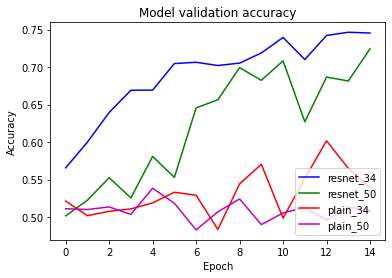

In [31]:
plt.plot(history_resnet_34.history['val_accuracy'], 'b')
plt.plot(history_resnet_50.history['val_accuracy'], 'g')
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='lower right')
plt.show()

## 결론

### 루브릭평가

1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? 
3. Ablation Study 결과가 바른 포맷으로 제출되었는가?

### 느낀 점

모델을 직접적으로 구현하는 것이 매우 어려웠다. 결국 다른 수강생들의 도움과 코드를 많이 참고해서 겨우 완성했던 것 같다. 아직 많이 부족한 것 같다. 그래프가 구현 된 것을 보면 ResNet-34 와 ResNet-50이 비교적 높은 정확도에서 비교할 수 있었고 빨간색과 보라색을 비교하면 Plain-34, Plain-50를 비교할 수 있었다. 각각의 비교 이외에도 Resnet과 Plain을 비교하면 Resnet모델이 더 안정적인 것을 볼 수 있었다. 

참고코드 : https://github.com/PEBpung/Aiffel/blob/master/Project/Going%20Deeper/G2.%20ResNet%20Ablation%20Study.ipynb